In [1]:
# 🥊 Rule number 1 of Search Club:
print("You do not talk about Search Club.")

You do not talk about Search Club.


In [2]:
# 🥊 Rule number 2 of Search Club:
print("You DO NOT talk about Search Club.")

You DO NOT talk about Search Club.


# Comparing Dense, Sparse, and Hybrid Search

This notebook demonstrates and compares three popular text search methods using the Urban Dictionary dataset:

- **Dense (Semantic) Search:** Uses neural embeddings to find semantically similar entries, even if they don't share exact words.
- **Sparse (Keyword) Search:** Uses classic TF-IDF to find entries that share keywords with the query.
- **Hybrid Search:** Combines both approaches for more robust results.

We will benchmark their speed, visualize their score distributions, and show qualitative results for various queries.

In [11]:
#original dataset link: https://www.kaggle.com/datasets/athontz/urban-dictionary-terms

In [1]:
import pandas as pd

In [3]:
raw_df = pd.read_csv("urban_dictionary.csv")
print(raw_df.shape)
raw_df.head()

(4272, 7)


,definition,word,author,tags,up,down,date
0,When a city or town specifically zones an area...,Jizzneyland,whocaresaboutNY,"[u'#jisneyland', u'#gizzneyland', u'#adult zon...",6267,6382,"April 05, 2013"
1,A toilet bowl.,trump basket,jknightx,[],729,634,"March 23, 2017"
2,Excellent health care reserved exclusively for...,wealth care,Davis Finch,"[u'#insurance', u'#rich', u'#america', u'#capi...",1072,625,"May 16, 2008"
3,A dick thing you say to a tall person to piss ...,hows the weather up there,Jackalfu,[],1428,580,"March 20, 2017"
4,"The insane, narcissistic, outrageous asshat wh...",ratfucker,FedupAngryLiberal,"[u'#trump', u'#asshat', u'#scum', u'#asshole',...",1580,2351,"March 18, 2017"


## Data Preparation

We combine the `word` and `definition` columns from the Urban Dictionary dataset into a single text field for each entry. This gives richer context for both semantic and keyword search.

In [4]:
# Prepare the text data for search

def get_texts(df):
    # Combine word and definition for richer context
    return (df['word'].astype(str) + '. ' + df['definition'].astype(str)).tolist()

texts = get_texts(raw_df)
print(f"Loaded {len(texts)} Urban Dictionary entries.")

# Example entry
print(texts[0])


Loaded 4272 Urban Dictionary entries.
Jizzneyland. When a city or town specifically zones an area for "adult" businesses.


## Dense (Semantic) Search

We use a pre-trained SentenceTransformer model to embed each entry and the search query into a high-dimensional vector space. Relevance is measured by cosine similarity between the query and each entry.

- **Advantage:** Finds semantically similar entries, even if they don't share exact words.
- **Example:** A search for "food" might return "pizza" or "snack" even if the word "food" isn't present.

In [5]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load model (downloads if not present)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute dense embeddings for all entries
embeddings = model.encode(texts, show_progress_bar=True)
np.save('urban_dense_embeddings.npy', embeddings)

# Dense search function
def dense_search(query, k=5):
    query_emb = model.encode([query])
    sims = cosine_similarity(query_emb, embeddings)[0]
    top_idx = np.argsort(sims)[::-1][:k]
    return raw_df.iloc[top_idx][['word', 'definition']], sims[top_idx]

# Example usage
dense_results, dense_scores = dense_search('funny insult', k=3)
print(dense_results)
print('Scores:', dense_scores)


C:\Users\mithu\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 134/134 [02:19<00:00,  1.04s/it]


            word                                         definition
2534  no offense  A phrase used to make insults seem socially ac...
2855   Slow Burn         An insult that doesn’t sink in for awhile.
2358  lol right?  1. Declaring that something is funny and askin...
Scores: [0.49496907 0.4666624  0.436396  ]


## Sparse (Keyword) Search

We use TF-IDF vectorization to represent each entry and the query as sparse vectors. Relevance is measured by the dot product (keyword overlap).

- **Advantage:** Finds entries that share exact words with the query.
- **Limitation:** Misses semantically related entries that use different words.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse
# Fit TF-IDF on all texts
tfidf = TfidfVectorizer()
sparse_matrix = tfidf.fit_transform(texts)

# Sparse search function
def sparse_search(query, k=5):
    query_vec = tfidf.transform([query])
    scores = (sparse_matrix @ query_vec.T).toarray().ravel()
    top_idx = np.argsort(scores)[::-1][:k]
    return raw_df.iloc[top_idx][['word', 'definition']], scores[top_idx]

# Example usage
sparse_results, sparse_scores = sparse_search('funny insult', k=3)
print(sparse_results)
print('Scores:', sparse_scores)
scipy.sparse.save_npz('urban_sparse_tfidf.npz', sparse_matrix)


               word                                         definition
3336        pay out                   To insult, dis' or burn someone.
100   Laughterwards  A TV show, Film or situation that was not real...
2855      Slow Burn         An insult that doesn’t sink in for awhile.
Scores: [0.31569124 0.31023123 0.27367866]


## Hybrid Search

We normalize and combine the scores from both dense and sparse search. This allows us to find entries that are either semantically or lexically relevant (or both).

- **Advantage:** Balances the strengths of both methods.
- **Formula:** `final_score = alpha * dense_score + (1 - alpha) * sparse_score`

In [7]:
from sklearn.preprocessing import MinMaxScaler

def hybrid_search(query, k=5, alpha=0.5):
    # Get dense and sparse scores for all entries
    query_emb = model.encode([query])
    dense_scores = cosine_similarity(query_emb, embeddings)[0]
    query_vec = tfidf.transform([query])
    sparse_scores = (sparse_matrix @ query_vec.T).toarray().ravel()
    # Normalize both
    scaler = MinMaxScaler()
    dense_norm = scaler.fit_transform(dense_scores.reshape(-1, 1)).ravel()
    sparse_norm = scaler.fit_transform(sparse_scores.reshape(-1, 1)).ravel()
    # Combine
    final_scores = alpha * dense_norm + (1 - alpha) * sparse_norm
    top_idx = np.argsort(final_scores)[::-1][:k]
    return raw_df.iloc[top_idx][['word', 'definition']], final_scores[top_idx]

# Example usage
hybrid_results, hybrid_scores = hybrid_search('funny insult', k=3, alpha=0.5)
print(hybrid_results)
print('Scores:', hybrid_scores)


               word                                         definition
2855      Slow Burn         An insult that doesn’t sink in for awhile.
3336        pay out                   To insult, dis' or burn someone.
100   Laughterwards  A TV show, Film or situation that was not real...
Scores: [0.91141435 0.8913334  0.82741288]


## Benchmarking and Visualization

We benchmark the search speed for each method and visualize the distribution of relevance scores for each query.

- **Timing Plot:** Shows how long each method takes to process a query.
- **Score Distribution Plot:** Shows how many entries have high/low relevance scores for a given query and method.

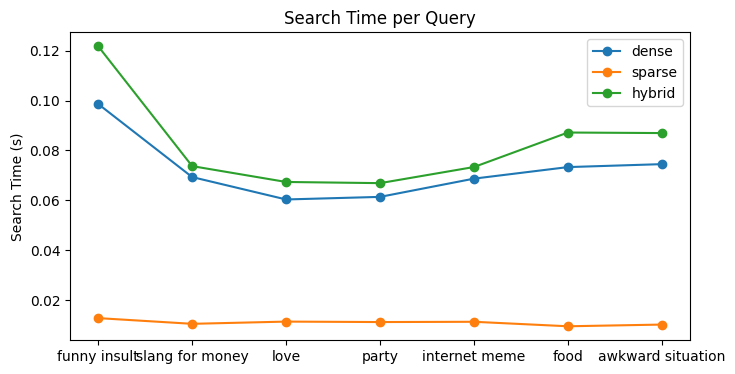

In [8]:
import time
import matplotlib.pyplot as plt
import seaborn as sns

# List of test queries (edit/add as you like)
test_queries = [
    'funny insult',
    'slang for money',
    'love',
    'party',
    'internet meme',
    'food',
    'awkward situation',
]

results = {'dense': [], 'sparse': [], 'hybrid': []}
times = {'dense': [], 'sparse': [], 'hybrid': []}

for q in test_queries:
    # Dense
    t0 = time.time()
    _, dense_scores = dense_search(q, k=len(raw_df))
    times['dense'].append(time.time() - t0)
    results['dense'].append(dense_scores)
    # Sparse
    t0 = time.time()
    _, sparse_scores = sparse_search(q, k=len(raw_df))
    times['sparse'].append(time.time() - t0)
    results['sparse'].append(sparse_scores)
    # Hybrid
    t0 = time.time()
    _, hybrid_scores = hybrid_search(q, k=len(raw_df))
    times['hybrid'].append(time.time() - t0)
    results['hybrid'].append(hybrid_scores)

# Plot timing
plt.figure(figsize=(8,4))
for method in times:
    plt.plot(test_queries, times[method], marker='o', label=method)
plt.ylabel('Search Time (s)')
plt.title('Search Time per Query')
plt.legend()
plt.show()


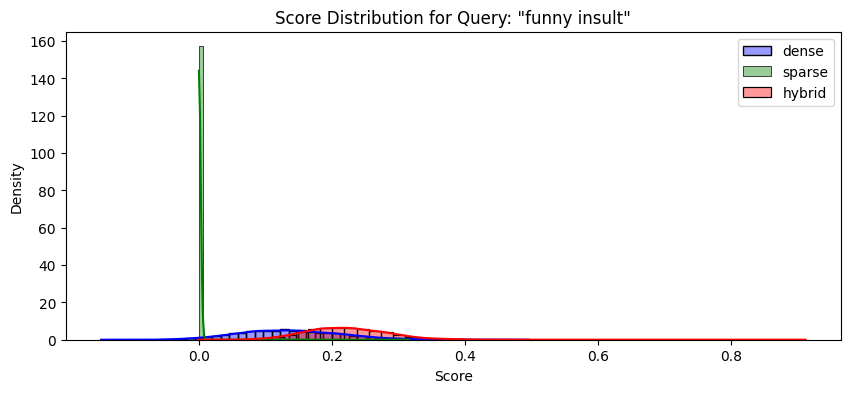

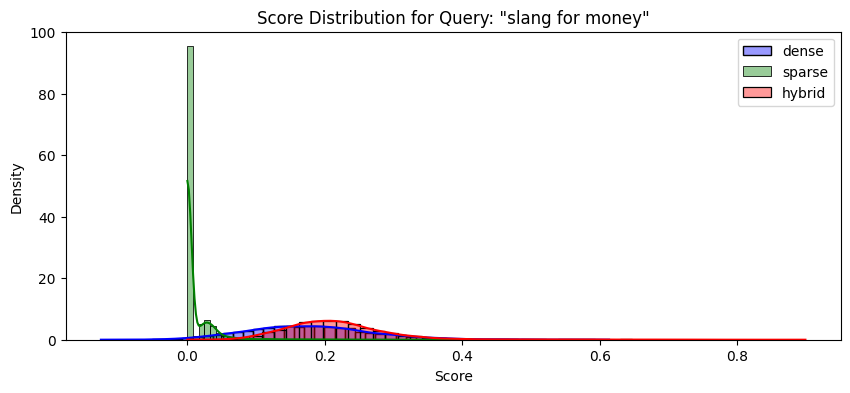

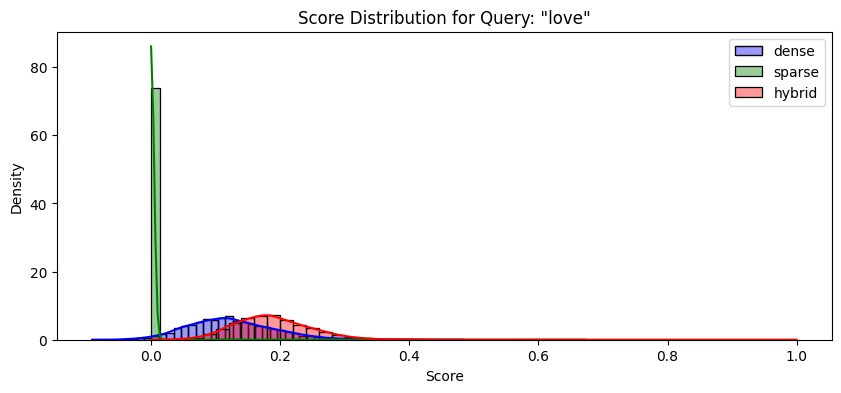

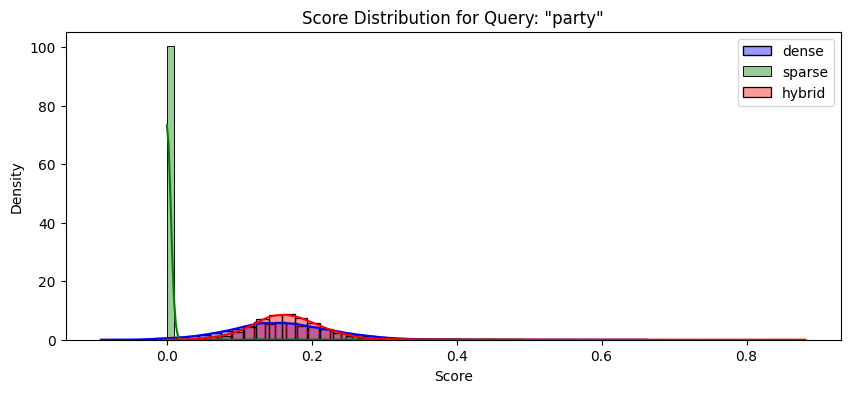

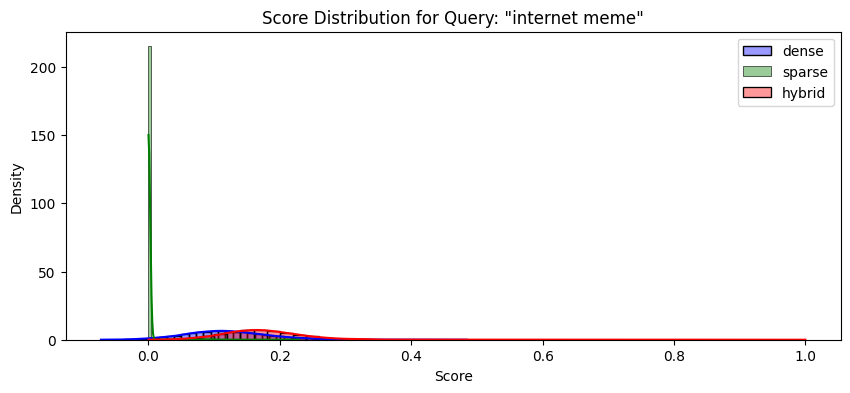

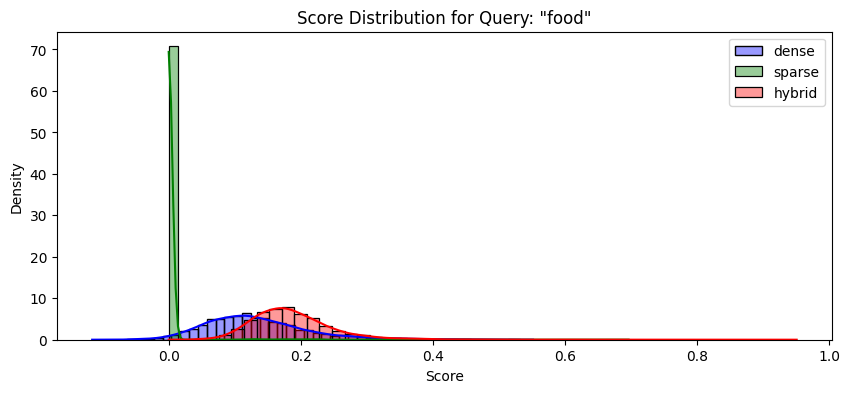

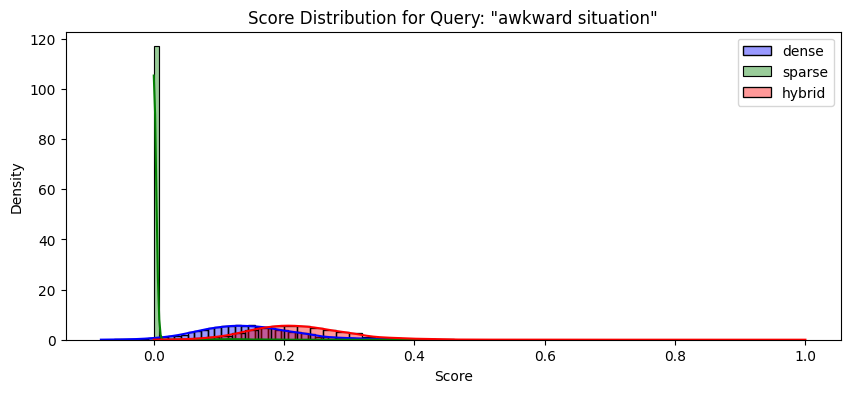

In [9]:
# Visualize score distributions for each method and query
for i, q in enumerate(test_queries):
    plt.figure(figsize=(10,4))
    for method, color in zip(['dense', 'sparse', 'hybrid'], ['blue', 'green', 'red']):
        sns.histplot(results[method][i], bins=50, color=color, label=method, kde=True, stat='density', alpha=0.4)
    plt.title(f'Score Distribution for Query: "{q}"')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


## Interpreting the Score Distribution Plot

- **X-axis:** Relevance score (normalized for hybrid).
- **Y-axis:** Density (how many entries have that score).
- **Blue (Dense):** Semantic similarity. Most entries have low similarity; a few are highly relevant.
- **Green (Sparse):** Keyword overlap. Most entries have zero score unless they share exact words with the query.
- **Red (Hybrid):** Combination. Can highlight both direct matches and semantically related entries.

**Takeaway:**  
Dense and hybrid search provide a smoother, more nuanced ranking, while sparse search is strict and only finds exact matches.

## Qualitative Results

For each query, we show the top results from each method. This helps illustrate the practical differences between semantic, keyword, and hybrid search.

In [10]:
# Show top results for each method and query
for q in test_queries:
    print(f'\nQuery: {q}\n' + '-'*40)
    for method, search_fn in zip(['Dense', 'Sparse', 'Hybrid'], [dense_search, sparse_search, hybrid_search]):
        print(f'\nTop 3 results ({method}):')
        results_df, scores = search_fn(q, k=3)
        for i, (word, definition) in enumerate(zip(results_df['word'], results_df['definition'])):
            print(f'{i+1}. {word}: {definition[:120]}...')



Query: funny insult
----------------------------------------

Top 3 results (Dense):
1. no offense: A phrase used to make insults seem socially acceptable....
2. Slow Burn: An insult that doesn’t sink in for awhile....
3. lol right?: 1. Declaring that something is funny and asking if others agree with you. Usually used in a sarcastic or obvious manner....

Top 3 results (Sparse):
1. pay out: To insult, dis' or burn someone....
2. Laughterwards: A TV show, Film or situation that was not really funny or marginally funny that for whatever reason is much funnier aftw...
3. Slow Burn: An insult that doesn’t sink in for awhile....

Top 3 results (Hybrid):
1. Slow Burn: An insult that doesn’t sink in for awhile....
2. pay out: To insult, dis' or burn someone....
3. Laughterwards: A TV show, Film or situation that was not really funny or marginally funny that for whatever reason is much funnier aftw...

Query: slang for money
----------------------------------------

Top 3 results (Dense):
1.

## Summary & Conclusion

- We explored and compared three search methods on the Urban Dictionary dataset:
    - **Dense (Semantic) Search:** Finds semantically similar entries using neural embeddings.
    - **Sparse (Keyword) Search:** Finds entries with direct keyword overlap using TF-IDF.
    - **Hybrid Search:** Combines both approaches for more robust and flexible results.

- We benchmarked the speed of each method and visualized how their relevance scores are distributed for different queries.

- **Dense search** excels at finding related concepts, even if the exact words don’t match.
- **Sparse search** is strict and only returns entries with direct keyword matches.
- **Hybrid search** balances both, often providing the most useful results in practice.

- Visualizations showed that dense and hybrid methods offer a smoother, more nuanced ranking, while sparse search is highly selective.

---

**Takeaway:**  
Modern search applications benefit from combining semantic and keyword-based approaches. Hybrid search provides both precision and flexibility, making it well-suited for real-world text retrieval tasks.

---

This workflow demonstrates how different search paradigms can be evaluated and visualized, helping you choose the best approach for your data and use case!